# BF case study with CNN using cylindrical padding 

Imports 

In [1]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Dense, Conv2D
from keras.layers.core import Activation, Lambda, Dropout, Flatten 
from keras.models import Model
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import np_utils

import numpy as np
import pandas as pd


from sklearn.cross_validation import train_test_split

import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.engine.topology import Layer,InputSpec


sess = tf.Session()
K.set_session(sess)
K.set_image_dim_ordering("th")



/home/rjpg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/rjpg/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Cylindrical Padding 

![alt text](images/cylindrical-padding.png "Title")


In [2]:
class CylindricalPad(Layer):

    def __init__(self, m=0,n=1, **kwargs):
        super(CylindricalPad, self).__init__(**kwargs)
        self.n = n
        self.m = m
        assert n > 0, 'n must be positive'
        
    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        super(CylindricalPad, self).build(input_shape)  
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    input_shape[2] + 2*self.m,
                    input_shape[3] + 2*self.n)

    def get_output_shape_for(self, input_shape):
        return (input_shape[0],
                    input_shape[1],
                    input_shape[2] + 2*self.m,
                    input_shape[3] + 2*self.n)
    
    def call(self,testElement, mask=None):
        firstColumns=testElement[:,:,:,0:self.n]
        lastColumns=testElement[:,:,:,testElement.shape[3]-self.n:testElement.shape[3]]
        result=tf.concat([testElement,firstColumns], axis=3)
        result=tf.concat([lastColumns,result], axis=3)
        if self.m != 0 :
            #x = tf.placeholder(result.dtype, shape=[result.shape[0],result.shape[1],self.m,result.shape[3]])
            #y = tf.zeros_like(x,dtype=result.dtype)
            
            firstRows=result[:,:,0:self.m,:]
            
            y = tf.fill(tf.shape(firstRows), 0.)
            
            #y=tf.fill([result.shape[0],result.shape[1],self.m,result.shape[3]],0.)
            
            #y = tf.constant(0., shape=[result.shape[0],result.shape[1],self.m,result.shape[3]],dtype=result.dtype)
            result=tf.concat([y,result], axis=2)
            result=tf.concat([result,y], axis=2)
        
        return result

    def get_config(self):
        config = {'CylindricalPad': self.cropping}
        base_config = super(CylindricalPad, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

print("CylindricalPad class layer defined")

CylindricalPad class layer defined


## Load Data 

In [19]:


df = pd.read_csv('../NNNormalizeData-out.csv',header=None) 

np.random.seed(42) # always shuffle the same way 
df = df.reindex(np.random.permutation(df.index)) # shuffle examples 
df.reset_index(inplace=True, drop=True)

print(df.shape) #shape[1] number of columns. [35] is the output column 

inputs = range(df.shape[1]-1) 
target = [df.shape[1]-1] 

total_inputs,total_output = df.as_matrix(inputs).astype(np.float32),df.as_matrix(target).astype(np.int32)

print(total_inputs[1])
print(total_output[1])


(19456, 36)
[-0.24243258 -0.08749072 -0.29287082  0.6741074   0.24049185  0.33029917
  1.          1.         -1.         -0.7249922  -1.          0.7532298
 -0.11201674 -0.3344884  -1.         -0.30554515 -0.16871902  1.
 -0.01614623 -1.          1.         -1.         -0.54619735  1.
 -1.          0.3173238   0.41633412  0.22356567  0.18282738  0.8827981
 -0.33021003 -0.21053794 -1.         -0.2780667   0.76594937]
[3]


/home/rjpg/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [20]:
total_inputs = np.reshape(total_inputs, (-1,5,7))
print(total_inputs[1])
print(total_output[1])

# 5 vars over 7 time steps 

[[-0.24243258 -0.08749072 -0.29287082  0.6741074   0.24049185  0.33029917
   1.        ]
 [ 1.         -1.         -0.7249922  -1.          0.7532298  -0.11201674
  -0.3344884 ]
 [-1.         -0.30554515 -0.16871902  1.         -0.01614623 -1.
   1.        ]
 [-1.         -0.54619735  1.         -1.          0.3173238   0.41633412
   0.22356567]
 [ 0.18282738  0.8827981  -0.33021003 -0.21053794 -1.         -0.2780667
   0.76594937]]
[3]


In [21]:
#Make transpose just to be compatible with LSTM (just in case we use some LSTM layer inside... )

total_inputs=np.transpose(total_inputs,(0,2,1))

# now 7 time steps of 5 variables 

print(total_inputs[1])
print(total_output[1])


[[-0.24243258  1.         -1.         -1.          0.18282738]
 [-0.08749072 -1.         -0.30554515 -0.54619735  0.8827981 ]
 [-0.29287082 -0.7249922  -0.16871902  1.         -0.33021003]
 [ 0.6741074  -1.          1.         -1.         -0.21053794]
 [ 0.24049185  0.7532298  -0.01614623  0.3173238  -1.        ]
 [ 0.33029917 -0.11201674 -1.          0.41633412 -0.2780667 ]
 [ 1.         -0.3344884   1.          0.22356567  0.76594937]]
[3]


## define CNN with cylindrical layers for padding 

In [22]:
class LeNet:
    @staticmethod
    def build(timeSteps,variables,classes):
        #CONV=>POOL
        inputNet = Input(shape=(1,timeSteps,variables)) 
        conv1=Conv2D(20,kernel_size=(5,2), padding="same")(inputNet)
        conv1=Activation("relu")(conv1)
        conv1=MaxPooling2D(pool_size=(2, 1), strides=(1, 1))(conv1)
        conv2=Conv2D(50,kernel_size=(5,3), padding="same")(conv1)
        conv2=MaxPooling2D(pool_size=(2, 1), strides=(1, 1))(conv2)
        conv2=Activation("relu")(conv2)
        out1=Dropout(0.40)(conv2)
        
        flatten=Flatten()(out1)
        denselayers=Dense(400)(flatten)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.5)(denselayers)
        denselayers=Dense(150)(denselayers)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.8)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(classes)(denselayers)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model
        
        
class LeNetCylindrical:
    @staticmethod
    def build(timeSteps,variables,classes):
        
        inputNet = Input(shape=(1,timeSteps,variables)) 
        
        cyPad1=CylindricalPad(m=2,n=2)(inputNet)
        conv1=Conv2D(20, (5,5), padding="valid")(cyPad1)
        conv1=Activation("relu")(conv1)
       
        cyPad2=CylindricalPad(m=2,n=2)(conv1)
        conv2=Conv2D(50,(5,5), padding="valid")(cyPad2)
        
        conv2=Activation("relu")(conv2)
        out1=Dropout(0.40)(conv2)
        flat=Flatten()(out1)
        denselayers=Dense(400)(flat)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.5)(denselayers)
        denselayers=Dense(150)(denselayers)
        denselayers=Activation("relu")(denselayers)
        denselayers=Dropout(0.8)(denselayers)
        # a softmax classifier
        classificationLayer=Dense(classes)(denselayers)
        classificationLayer=Activation("softmax")(classificationLayer)
        
        model=Model(inputNet,classificationLayer)
        return model
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 7, 5)           0         
_________________________________________________________________
cylindrical_pad_3 (Cylindric (None, 1, 11, 9)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 7, 5)          520       
_________________________________________________________________
activation_6 (Activation)    (None, 20, 7, 5)          0         
_________________________________________________________________
cylindrical_pad_4 (Cylindric (None, 20, 11, 9)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 7, 5)          25050     
_________________________________________________________________
activation_7 (Activation)    (None, 50, 7, 5)          0         
__________

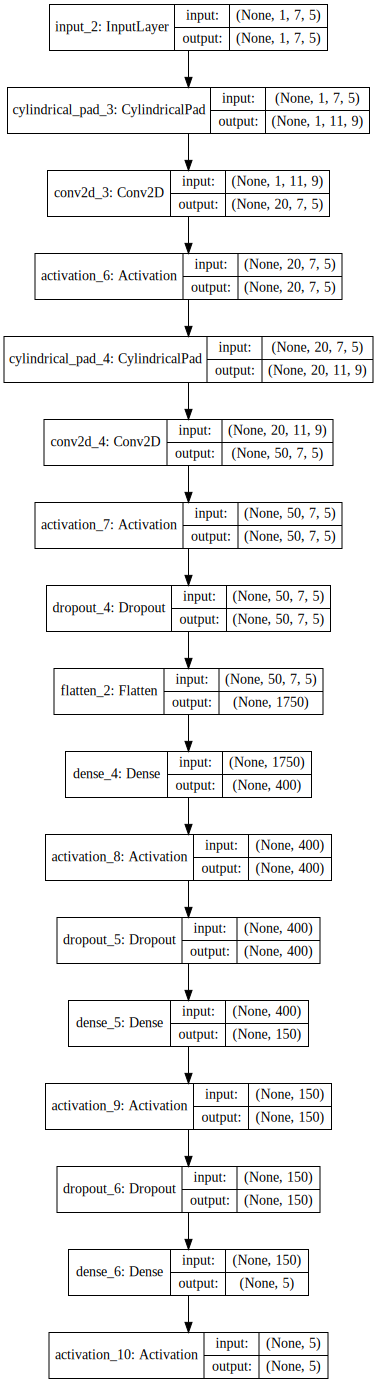

In [23]:
modeltest=LeNetCylindrical.build(timeSteps=7,variables=5,classes=5)
modeltest.compile(optimizer=Adam(), loss="categorical_crossentropy",metrics=["accuracy"])
modeltest.summary() 

#plot_model(modeltest, to_file="model.png",show_shapes=True)

#plot_model(modeltest, to_file="model.png",show_shapes=True)
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(modeltest,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [24]:
X_train=total_inputs
y_train=total_output


NB_EPOCH = 200
# network and training
BATCH_SIZE = 64
VERBOSE = 1
OPTIMIZER = Adam()
VALIDATION_SPLIT=0.2
NB_CLASSES = 5  # number of outputs = number of classes

print("-------------- [0 , 1] ----------------------")
X_train += 1 
X_train /= 2
print(X_train.shape)
#X_test += 1  

# we need a 60K x [1 x 28 x 28] shape as input to the CONVNET
X_train = X_train[:, np.newaxis, :, :]
#X_test = X_test[:, np.newaxis, :, :]


print(X_train.shape, 'train samples')
#print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, NB_CLASSES)
#y_test = np_utils.to_categorical(y_test, NB_CLASSES)

sess.run(tf.global_variables_initializer())


tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_lr=0.001)

history = modeltest.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_split=VALIDATION_SPLIT, callbacks=[tbCallBack,reduce_lr,esCallBack])

-------------- [0 , 1] ----------------------
(19456, 7, 5)
(19456, 1, 7, 5) train samples
Train on 15564 samples, validate on 3892 samples
Epoch 1/200
15564/15564 [==============================] - 2s 143us/step - loss: 1.6004 - acc: 0.2417 - val_loss: 1.5952 - val_acc: 0.2474
Epoch 2/200
15564/15564 [==============================] - 2s 122us/step - loss: 1.5959 - acc: 0.2500 - val_loss: 1.5935 - val_acc: 0.2474
Epoch 3/200
15564/15564 [==============================] - 2s 121us/step - loss: 1.5947 - acc: 0.2494 - val_loss: 1.5927 - val_acc: 0.2474
Epoch 4/200
15564/15564 [==============================] - 2s 121us/step - loss: 1.5902 - acc: 0.2573 - val_loss: 1.5857 - val_acc: 0.2610
Epoch 5/200
15564/15564 [==============================] - 2s 120us/step - loss: 1.5828 - acc: 0.2632 - val_loss: 1.5689 - val_acc: 0.2757
Epoch 6/200
15564/15564 [==============================] - 2s 119us/step - loss: 1.5649 - acc: 0.2792 - val_loss: 1.5525 - val_acc: 0.2891
Epoch 7/200
15564/15564 [=

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


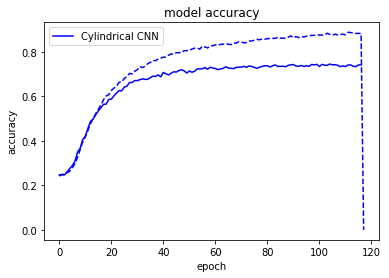

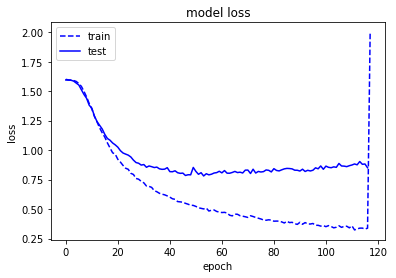

In [53]:
print(history.history.keys())
# summarize history for accuracy
acc=np.array(history.history['acc'])
#acc=acc[0:100]
acc=np.append(acc,[0])
plt.plot(acc,'b--')
plt.plot(history.history['val_acc'],'b',label='Cylindrical CNN')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(history.history['loss'])
loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(history.history['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##LR ??
#lr=np.array(history.history['lr'])
#lr=np.append(lr,[0])
#plt.plot(lr,'b-')
#plt.title('lr values')
#plt.ylabel('lr')
#plt.xlabel('epoch')
#plt.legend(loc='upper left')
#plt.show()
